### Trabajo Final Master Ciencia de Datos y Business Analytics
## Reporte Laboratorio Seco - Modelo de Predicción ARIMA
Septiembre 9, 2023

## Introducción
El siguiente cuaderno de laboratorio es un registro de la aplicación de un modelo ARIMA con el objetivo de encontrar el pronóstico adecuado a la data de POS de Sportline Colombia.

## Lectura de Datos y Adecuación de las Variables
Para el entrenamiento de los datos, es importante leerlos del archivo de juegos de datos POS del datamart. En este caso en particular, se leen los datos extraidos para el TFM correspondientes a las ventas de Sportline America Colombia del 1 de enero del 2018 al 30 de julio del 2023.

In [1]:
# Importar y leer archivo como DF Pandas
# Los archivos se leen de los formatos por año ya limpios

import pandas as pd
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CODIGO_MARCA  9069 non-null   float64
 1   FECHA         9069 non-null   object 
 2   CANTIDAD      9069 non-null   int64  
 3   WEEK_OF_YEAR  9069 non-null   object 
 4   YEAR          9069 non-null   int64  
 5   MONTH         9069 non-null   object 
 6   XMAS          9069 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 496.1+ KB


Un modelo ARIMA no necesita más que un juego de datos y su respectiva fecha. Por lo tanto podemos prescindir de muchas variables que en la metodología de ARIMA no nos sirven. 

El juego de entrenamiento finalmente filtra los datos para la marca 456, que es la categoría de zapatillas.

In [2]:
# Preparar el archivo para entrenamiento
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
columns_to_drop = ['WEEK_OF_YEAR', 'XMAS', 'YEAR', 'MONTH']
dfPOS = dfPOS.drop(columns=columns_to_drop)
data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]

Antes de comenzar el entrenamiento, revisemos una vez más la topología de la data para asegurarnos que tiene el valor esperado.

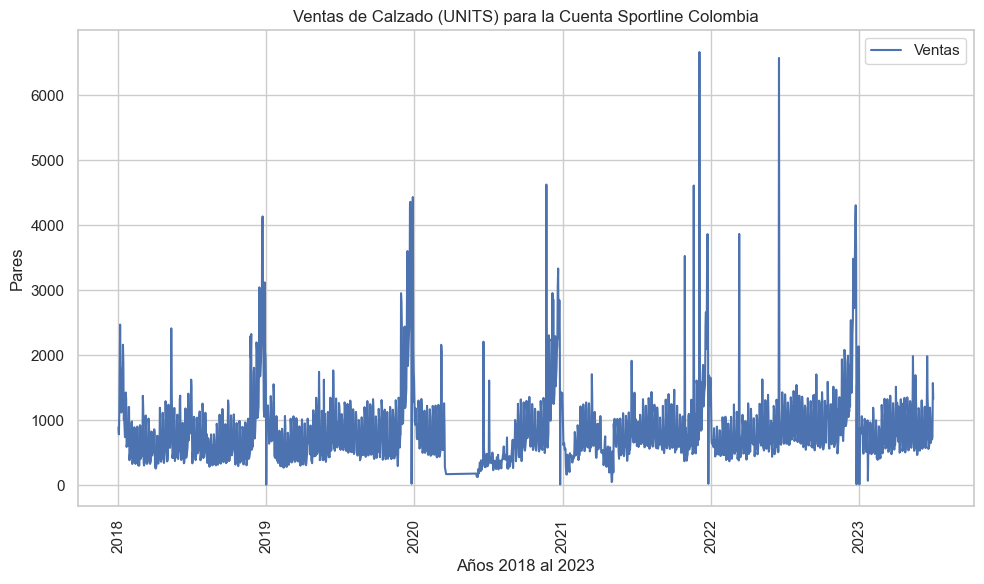

In [3]:
# Revisar la topologia de la serie de tiempos
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar la data por 'CODIGO_MARCA', y la semana del año
data_temp = data_train[['FECHA', 'CANTIDAD']].sort_values(by='FECHA', ascending=True)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='FECHA', y='CANTIDAD', data=data_temp, label='Ventas')
plt.title('Ventas de Calzado (UNITS) para la Cuenta Sportline Colombia')
plt.xlabel('Años 2018 al 2023')
plt.ylabel('Pares')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()  # Add a legend to label the line

plt.show()

## Entrenamiento de Datos
Para el entrenamiento de datos se utilizó la librería `statsmodels.tsa.arima.model`. La libreria `statsmodels.tsa.arima.model` es un módulo dentro de la biblioteca _Statsmodels_ en Python que proporciona clases y funciones para trabajar con modelos de series de tiempo de media móvil integrada autorregresiva (ARIMA). ARIMA es un método estadístico ampliamente utilizado para modelar y pronosticar datos de series de tiempo. 

In [4]:
import warnings
warnings.filterwarnings('ignore')
# Setear 'FECHA' como el index del DF
data_train.set_index('FECHA', inplace=True)

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Hay que ajustar la data a la frecuencia indicada.
# En nuestro caso de 'D' de diario
df_resampled = data_train.resample('D').sum()

# Chequear la estacionalidad con el test de Dicky-Fuller
result = adfuller(df_resampled['CANTIDAD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.751509097136997
p-value: 5.951608088866386e-07


El valor del p-estadístico es muy bajo (`p-value: 5.951608088866386e-07`) lo que significa que la serie tiene estacionalidad y no hay que ajustar nada. Veamos la gráfica ACF (Función de Auto Correlación) para detectar pistas visuales del juego de datos.   

Aqui vale la pena explicar un poco que pasa detrás de las funciones de la libreria. La función `plot_pacf` en muchas bibliotecas de análisis de series temporales, incluido _Statsmodels_, generalmente genera dos gráficos cuando se llama con el argumento lags:

1. __Gráfico de la función de autocorrelación parcial (PACF):__ el gráfico principal es el gráfico PACF, que muestra los coeficientes de autocorrelación parcial para diferentes valores de retraso. Cada barra del gráfico representa la autocorrelación parcial en un rezago específico y las líneas verticales indican los intervalos de confianza. El gráfico PACF ayuda a identificar el orden del componente autorregresivo (AR) en un modelo de serie temporal.

2. __Gráfico de función de autocorrelación (ACF):__ el gráfico secundario, que también se puede ver al usar `plot_pacf`, es el gráfico ACF. Muestra los coeficientes de autocorrelación para diferentes valores de rezago. El gráfico ACF puede resultar útil para identificar el orden del componente de media móvil (MA) en un modelo de serie temporal.

Ambos gráficos pueden proporcionar información sobre la estructura de los datos de series temporales, pero se centran en aspectos diferentes:

1. PACF se utiliza principalmente para identificar el componente AR y se buscan picos significativos en el gráfico PACF.
2. ACF se utiliza principalmente para identificar el componente MA y se buscan picos significativos en el gráfico ACF.

Generalmente, si se ven dos gráficos que tienen el mismo aspecto cuando llama a `plot_pacf`, es posible que no haya una distinción clara entre los componentes AR y MA en sus datos, y que tanto los gráficos PACF como ACF muestren patrones similares. Esto puede suceder cuando su serie temporal no muestra patrones AR o MA fuertes, o tiene una estructura ARIMA mixta donde ambos componentes contribuyen a la autocorrelación.

Esto no es necesariamente una buena señal, ya que no nos facilita determinar elementos para fijar la serie _ARIMA(p,d,q)_ de forma visual. Es interesante ver como la serie degrada como una función coseno de patrón decreciente.

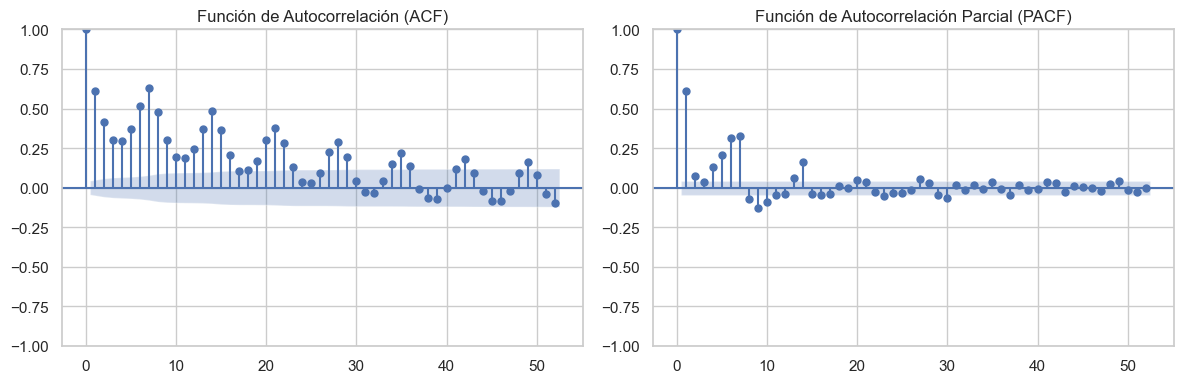

In [5]:
import matplotlib.pyplot as plt

# Create ACF and PACF plots
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(df_resampled['CANTIDAD'], lags=52, ax=plt.gca(), title='Función de Autocorrelación (ACF)')

plt.subplot(122)
plot_pacf(df_resampled['CANTIDAD'], lags=52, ax=plt.gca(), title='Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

Para facilitar la selección correcta de los valores `ARIMA(p, d, q)` utilizaremos la librería _pmdarima_. La librería _pmdarima_ (abreviatura de "Python Auto-ARIMA") es una biblioteca Python de código abierto que proporciona herramientas para seleccionar automáticamente los mejores modelos ARIMA y SARIMA para pronósticos y análisis de series temporales. Está construida sobre modelos estadísticos y ofrece una interfaz fácil de usar para la selección y pronóstico de modelos, lo que facilita a los científicos y analistas de datos trabajar con datos de series temporales.

Algunas de las ventajas de esta librería son:

1. __Selección automática de modelo ARIMA:__ la característica principal de pmdarima es su función auto_arima, que automatiza el proceso de selección del mejor modelo ARIMA o SARIMA para una serie de tiempo determinada. Realiza una búsqueda sistemática sobre diferentes combinaciones de órdenes ARIMA (p, d, q) y opcionalmente órdenes estacionales (P, D, Q, s) para encontrar el modelo con el AIC (Criterio de información de Akaike) o BIC (Criterio de información bayesiano) más bajo. ) valor.

2. __Descomposición estacional:__ pmdarima proporciona funciones para la descomposición estacional de datos de series temporales, lo que ayuda a los usuarios a comprender y visualizar patrones estacionales en los datos.

3. __Herramientas de trazado:__ la biblioteca incluye funciones de trazado para visualizar datos de series temporales, ACF (función de autocorrelación), PACF (función de autocorrelación parcial) y diagnóstico de modelos.

In [6]:
import pmdarima as pm
model_auto = pm.auto_arima(df_resampled['CANTIDAD'], seasonal=False, stepwise=True, suppress_warnings=True)

# Resumen del Modelo ARIMA
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2008
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -14928.702
Date:                Sun, 01 Oct 2023   AIC                          29873.404
Time:                        18:16:36   BIC                          29918.239
Sample:                    01-02-2018   HQIC                         29889.864
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4098      0.024     17.078      0.000       0.363       0.457
ar.L2         -0.5601      0.017    -32.409      0.000      -0.594      -0.526
ar.L3         -0.3238      0.018    -17.622      0.0

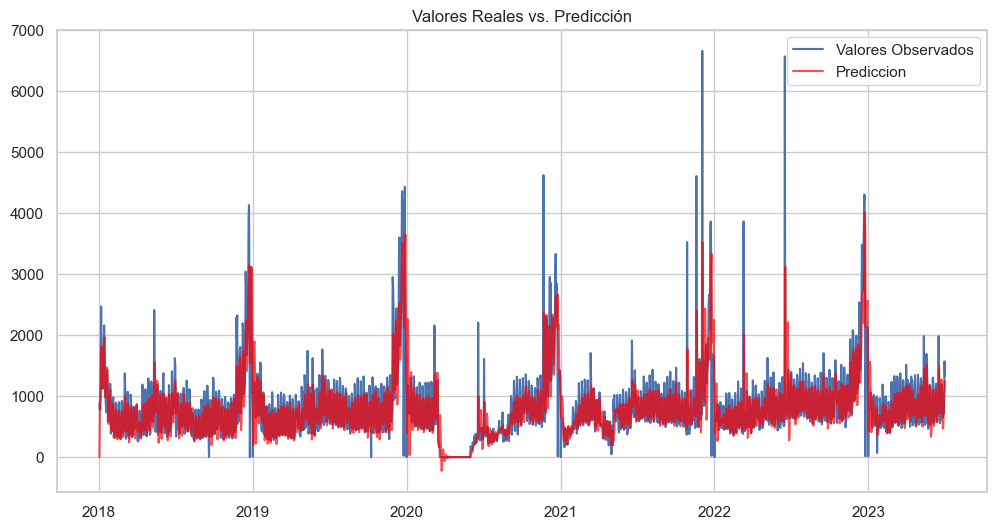

In [7]:
# Plot Valores Reales vs. Predicción
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['CANTIDAD'], label='Valores Observados')
plt.plot(model_auto.predict_in_sample(), color='red', label='Prediccion', alpha=0.7)
plt.legend(loc='best')
plt.title('Valores Reales vs. Predicción')
plt.show()

Como usamos el MSE y R2 para evaluar el modelo de regresión lineal y el modelo mejorado polinómico de cuarto grado, hagamos lo mismo con los resultados de ARIMA.

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

forecast = model_auto.predict_in_sample()
actual_values = df_resampled['CANTIDAD'].values
mse = mean_squared_error(actual_values, forecast)
r2 = r2_score(actual_values, forecast)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 169561.4663940259
R-squared (R2): 0.5301378334129916


El resultado de ARIMA es muy superior a los métodos de regresión:

|                   |    MSE    |     R2    |
|-------------------|:---------:|:---------:|
| Regresión Lineal  | 243568.12 |  0.18     |
| Polinomio 4 Grado | 181688.81 |  0.39     |
| Arima (5,1,2)     | 169561.47 |  0.53     |

Hemos avanzado mucho desde el primer modelo estudiado, pero estamos lejos de un valor R2 del 0.95 o superior. Para ver como podemos mejorar el modelo, creamos una visualización de los residuos:

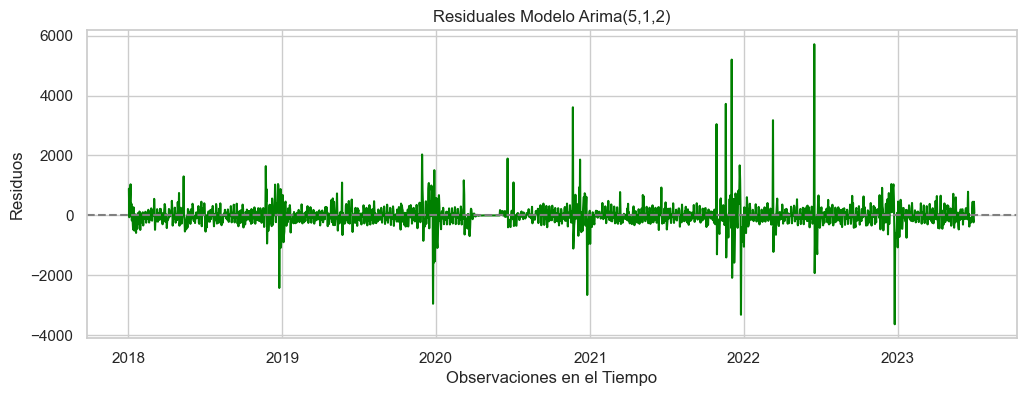

In [9]:
import matplotlib.pyplot as plt
f = model_auto.predict_in_sample()
actual_values = df_resampled['CANTIDAD'].values
time_index = df_resampled.index

residuals = actual_values - f

plt.figure(figsize=(12, 4))
plt.plot(time_index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='gray', linestyle='--', label='Zero Residuals Line')
plt.title('Residuales Modelo Arima(5,1,2)')
plt.xlabel('Observaciones en el Tiempo')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()

El modelo parece tener un grado de heterocedasticidad implicita. Para facilitar la detección de un patrón, procedemos a graficar los residuos junto con la desviación estándar móvil.

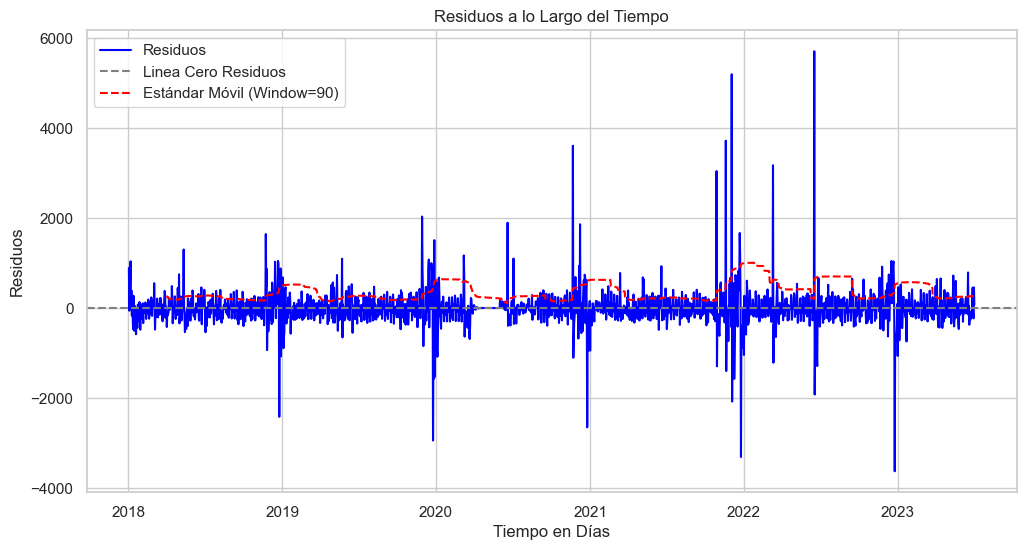

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(time_index, residuals, label='Residuos', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', label='Linea Cero Residuos')

window = 90  # Las temporadas en la industria tienen 90 dias
rolling_std = residuals.rolling(window=window).std()  
plt.plot(time_index, rolling_std, label=f'Estándar Móvil (Window={window})', color='red', linestyle='--')

plt.title('Residuos a lo Largo del Tiempo')
plt.xlabel('Tiempo en Días')
plt.ylabel('Residuos')
plt.legend()
plt.grid(True)
plt.show()

Es evidente que hay un patrón en los residuos que limita nuestra capacidad de extraer el modelo final de la data. 

## Variación 1: GARCH
Probamos con la libreria GARCH. Consideramos aquí modelos de series de tiempo alternativos diseñados para manejar la heterocedasticidad, como los modelos GARCH (_heterocedasticidad condicional autorregresiva generalizada_). Los modelos GARCH modelan y estiman explícitamente varianzas que varían en el tiempo.

In [11]:
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

actual_values = df_resampled['CANTIDAD'].values
time_index = df_resampled.index

# Calcular los residuos al cuadrado (para el modelado con GARCH)
squared_residuals = (actual_values - actual_values.mean())**2

# Definir y calzar un modelo GARCH(1, 1) 
model = arch_model(squared_residuals, vol='Garch', p=1, q=1)
results = model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34812.50556950929
Iteration:      2,   Func. Count:     12,   Neg. LLF: 31068.41185767699
Iteration:      3,   Func. Count:     17,   Neg. LLF: 31106.484280767454
Iteration:      4,   Func. Count:     23,   Neg. LLF: 31067.574904252193
Iteration:      5,   Func. Count:     28,   Neg. LLF: 31067.57490289375
Iteration:      6,   Func. Count:     32,   Neg. LLF: 31067.57489973504
Optimization terminated successfully    (Exit mode 0)
            Current function value: 31067.57490289375
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -31067.6
Distribution:                  Normal   AIC

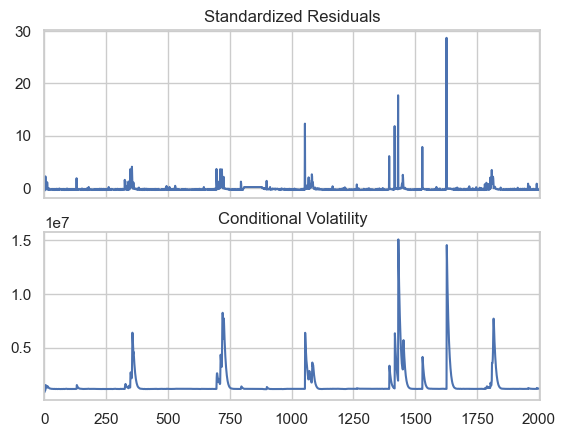

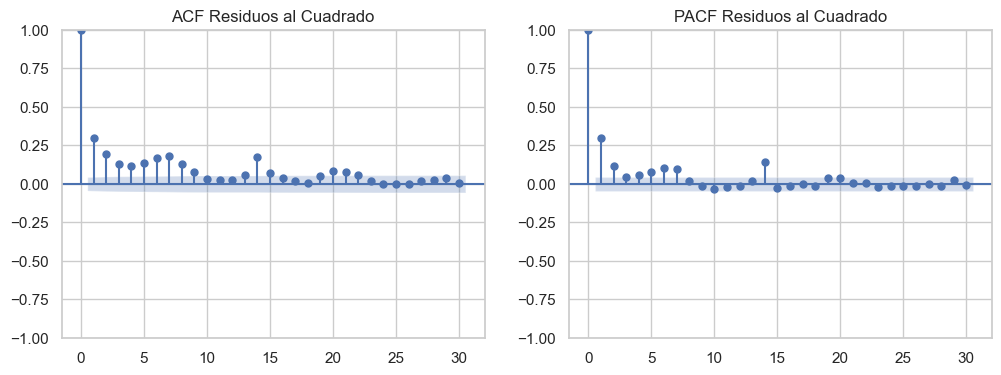

In [12]:
# Plot GARCH 
results.plot()

# Plot ACF y PACF de residuos al cuadrado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(squared_residuals, lags=30, ax=ax1, title='ACF Residuos al Cuadrado')
plot_pacf(squared_residuals, lags=30, ax=ax2, title='PACF Residuos al Cuadrado')
plt.show()

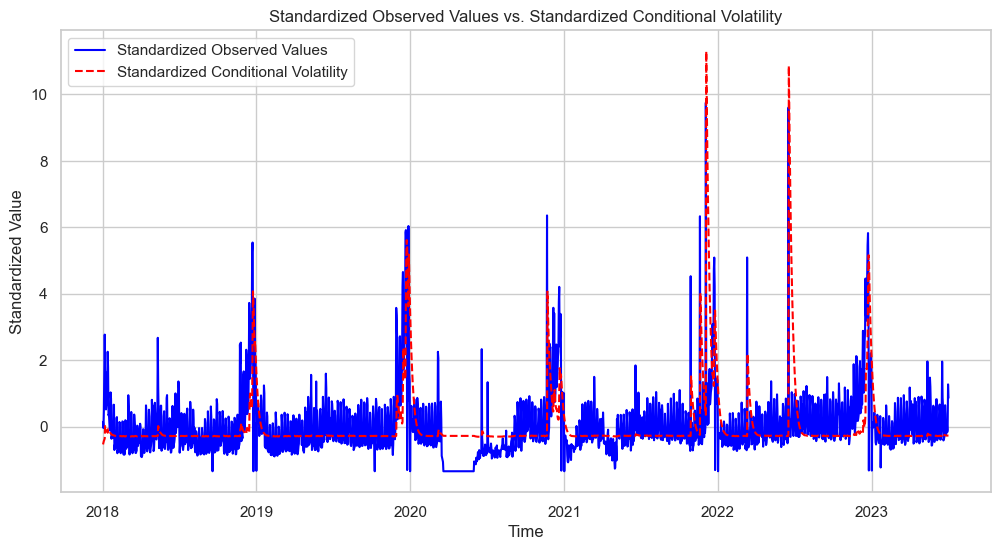

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Standardize the observed values and conditional volatility
standardized_actual = (actual_values - np.mean(actual_values)) / np.std(actual_values)
conditional_volatility = results.conditional_volatility
standardized_volatility = (conditional_volatility - np.mean(conditional_volatility)) / np.std(conditional_volatility)

# Plot standardized values
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, standardized_actual, label='Standardized Observed Values', color='blue')
plt.plot(df_resampled.index, standardized_volatility, label='Standardized Conditional Volatility', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Standardized Value')
plt.title('Standardized Observed Values vs. Standardized Conditional Volatility')
plt.legend()
plt.grid(True)
plt.show()

La gráfica anterior es indicativa de muchas cosas, pero no de un modelo de predicción. Hay una diferencia de escala entre los valores observados y la volatilidad condicional prevista al compararlos directamente porque representan diferentes aspectos de la serie temporal.

1. __Valores observados (valores_actuales):__ estos son los valores reales de su serie temporal. Representan los puntos de datos que se intenta modelar o pronosticar. Por lo general, están en la misma escala que los datos originales, que podrían estar en unidades como ventas, temperatura, precios de acciones, etc.

2. __Volatilidad condicional prevista (volatilidad_condicional):__ estos valores representan la varianza o volatilidad prevista de la serie temporal, no los valores de datos reales. La volatilidad es una medida de cuán dispersos o variables son los puntos de datos. La escala de la volatilidad condicional suele ser mayor que la de los datos originales porque mide la varianza, que a menudo se eleva al cuadrado.

Si bien este análisis es interesante, se aleja mucho de nuestra línea de estudio de un modelo parsimonioso - sencillo y robusta - que sea fácil de interpretar por el equipo de planificación de la empresa. 

## Variación 2: Adicionar Variables Exógenas al Modelo ARIMA
La librería `pmdarima` permite agregar variables exógenas al modelo ARIMA. Para tal fin, tenemos que volver a construir el juego de datos agregando dos variables que estaban presente en el modelo de regresión: `XMAS` para la época de navidad y `COVID` para la temporada en la cual las tiendas estuvieron sujetas a restricción de ventas en Colombia por la pandemia. 

In [16]:
# Leer archivo 
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS2 = pd.read_csv(csv_file_path, encoding=encoding)

# Preparar el archivo para entrenamiento
dfPOS2['FECHA'] = pd.to_datetime(dfPOS2['FECHA'], format= '%Y-%m-%d')

# Crear YEAR y MONTH extraidas de la columna FECHA
dfPOS2['YEAR'] = dfPOS2['FECHA'].dt.year
dfPOS2['MONTH'] = dfPOS2['FECHA'].dt.month

# Crear la variable XMAS para saber que es mes de ventas de navidad =)
dfPOS2['XMAS'] = dfPOS2['MONTH'].apply(lambda x: 1 if x == 1 else 0)

# Crear la variable COVID para saber que en ese momento estaba el país en cierre parcial
# Define the date range for COVID-19 lockdowns
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-08-01')
dfPOS2['COVID'] = dfPOS2['FECHA'].apply(lambda date: 1 if pd.to_datetime('2020-03-01') <= date 
                                    < pd.to_datetime('2020-08-01') else 0)

data_train2 = dfPOS2[dfPOS2['CODIGO_MARCA'] == 456]

Antes de el entrenamiento vamos a asegurarnos que la serie es estacionaria. No hemos cambiado los valores de las cantidades, por lo que no vemos que la estacionalidad deba cambiar, pero el rigor científico nos lleva a hacer la prueba. 

In [17]:
# Entrenamiento de Datos
import warnings
warnings.filterwarnings('ignore')

# Setear 'FECHA' como el index del DF
data_train2.set_index('FECHA', inplace=True)

# Hay que ajustar la data a la frecuencia indicada.
# En nuestro caso de 'D' de diario
df_resampled2 = data_train2.resample('D').sum()

# Chequear la estacionalidad con el test de Dicky-Fuller
result = adfuller(df_resampled['CANTIDAD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.751509097136997
p-value: 5.951608088866386e-07


El valor del p-estadístico es muy bajo (p-value: 5.951608088866386e-07) lo que significa que la serie tiene estacionalidad y no hay que ajustar nada. Proseguimos con el entrenamiento.

In [18]:
y = df_resampled2['CANTIDAD']
X = df_resampled2[['COVID', 'XMAS', 'YEAR', 'MONTH']]

model_auto2 = pm.auto_arima(y, exogenous=X, seasonal=True, stepwise=True, suppress_warnings=True)

# Resumen del Modelo ARIMA
print(model_auto2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2008
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -14928.702
Date:                Sun, 01 Oct 2023   AIC                          29873.404
Time:                        18:24:37   BIC                          29918.239
Sample:                    01-02-2018   HQIC                         29889.864
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4098      0.024     17.078      0.000       0.363       0.457
ar.L2         -0.5601      0.017    -32.409      0.000      -0.594      -0.526
ar.L3         -0.3238      0.018    -17.622      0.0

El resumen del resultado es muy similar al entrenamiento de datos sin variables exogenas. Para evaluar los resultados visualmente utilizamos una gráfica donde sobreponemos los valores reales con los valores de predicción.

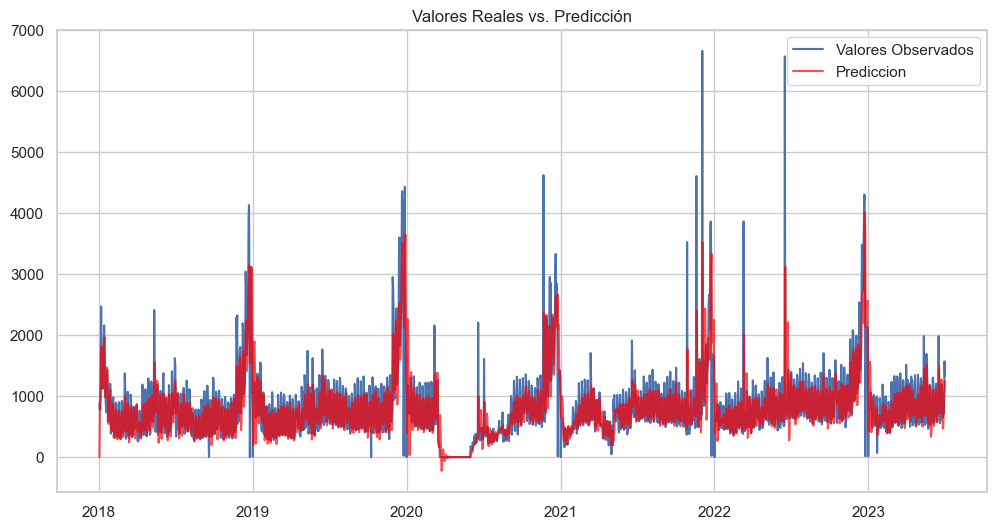

In [19]:
# Plot Valores Reales vs. Predicción
plt.figure(figsize=(12, 6))
plt.plot(df_resampled2['CANTIDAD'], label='Valores Observados')
plt.plot(model_auto2.predict_in_sample(), color='red', label='Prediccion', alpha=0.7)
plt.legend(loc='best')
plt.title('Valores Reales vs. Predicción')
plt.show()

La gráfica del modelo con variables exógenas se ve idéntica al modelo ARIMA(5,1,2). La última prueba es ver los resultados del error cuadrático y el R2. 

In [20]:
forecast2 = model_auto2.predict_in_sample()
actual_values2 = df_resampled2['CANTIDAD'].values
mse = mean_squared_error(actual_values2, forecast2)
r2 = r2_score(actual_values2, forecast2)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 169561.4663940259
R-squared (R2): 0.5301378334129916


La conclusión del modelo con el uso de variables exógenas es que no ha mejorado para nada el valor de predicción del modelo ARIMA original, y por lo tanto queda descartado. 

## Variación 3: Términos Interacción de Características
Los complejos efectos colaborativos de las características hacia la predicción de una variable se denominan __interacción de características__. Otro aspecto de la interacción de características es la variación de una característica con respecto a otra con la que interactúa. Estas variables a menudo se denominan variables de interacción (Krishnamurthy, S., 2023).

Identificar las interacciones de características presentes en su conjunto de datos puede resultar útil por varios motivos, entre ellos:

* Comprender las relaciones entre las características de su conjunto de datos y su efecto en la predicción y evitar sesgos al interpretar modelos con solo los efectos principales y no los efectos interactivos.
* Usar la información sobre interacciones para construir explícitamente modelos expresivos.
* Funciones de ingeniería para mejorar el rendimiento del modelo.

En nuestro caso en particular pensamos valioso potenciar las variables de períodos de venta extraordinaria por navidad y las ventas bajas de pandemia. En el uso de variables exógenas estas parecieron no tener mayor efecto. Pero quizás el uso de interacciones en pares aumente la señal de estos regresores. 

In [22]:
# Leer archivo 
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS3 = pd.read_csv(csv_file_path, encoding=encoding)

# Preparar el archivo para entrenamiento
dfPOS3['FECHA'] = pd.to_datetime(dfPOS3['FECHA'], format= '%Y-%m-%d')
dfPOS3['WEEK_LAST_TWO_DIGITS'] = dfPOS3['WEEK_OF_YEAR'].str[-2:]
dfPOS3['WEEK_LAST_TWO_DIGITS'] = pd.to_numeric(dfPOS3['WEEK_LAST_TWO_DIGITS'])

# Crear YEAR y MONTH extraidas de la columna FECHA
dfPOS3['YEAR'] = dfPOS3['FECHA'].dt.year
dfPOS3['MONTH'] = dfPOS3['FECHA'].dt.month

# Crear la variable XMAS para saber que es mes de ventas de navidad =)
dfPOS3['XMAS'] = dfPOS3['MONTH'].apply(lambda x: 1 if x == 1 else 0)

# Crear la variable COVID para saber que en ese momento estaba el país en cierre parcial
# Define the date range for COVID-19 lockdowns
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-08-01')
dfPOS3['COVID'] = dfPOS2['FECHA'].apply(lambda date: 1 if pd.to_datetime('2020-03-01') <= date 
                                    < pd.to_datetime('2020-08-01') else 0)

data_train3 = dfPOS3[dfPOS3['CODIGO_MARCA'] == 456]

import warnings
warnings.filterwarnings('ignore')

# Setear 'FECHA' como el index del DF
data_train3.set_index('FECHA', inplace=True)

# Hay que ajustar la data a la frecuencia indicada.
# En nuestro caso de 'D' de diario
df_resampled3 = data_train3.resample('D').sum()

In [23]:
# Crear términos
df_resampled3['COVID_MONTH'] = df_resampled3['COVID'] * df_resampled3['MONTH']
df_resampled3['XMAS_WEEK_OF_YEAR'] = df_resampled3['XMAS'] * df_resampled3['WEEK_LAST_TWO_DIGITS']

In [24]:
from sklearn.model_selection import train_test_split

# Define your features (including the interaction terms) and target variable
X = df_resampled3[['COVID', 'XMAS', 'COVID_MONTH', 'XMAS_WEEK_OF_YEAR']]
y = df_resampled3['CANTIDAD']

model_auto3 = pm.auto_arima(y, exogenous=X, seasonal=True, stepwise=True, suppress_warnings=True)

# Resumen del Modelo ARIMA
print(model_auto3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2008
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -14928.702
Date:                Sun, 01 Oct 2023   AIC                          29873.404
Time:                        18:25:18   BIC                          29918.239
Sample:                    01-02-2018   HQIC                         29889.864
                         - 07-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4098      0.024     17.078      0.000       0.363       0.457
ar.L2         -0.5601      0.017    -32.409      0.000      -0.594      -0.526
ar.L3         -0.3238      0.018    -17.622      0.0

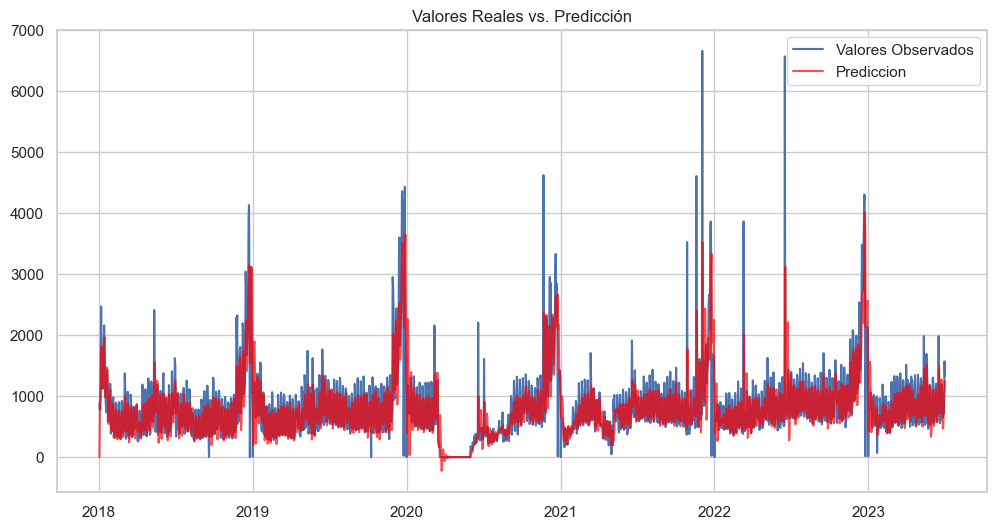

In [25]:
# Plot Valores Reales vs. Predicción
plt.figure(figsize=(12, 6))
plt.plot(df_resampled3['CANTIDAD'], label='Valores Observados')
plt.plot(model_auto3.predict_in_sample(), color='red', label='Prediccion', alpha=0.7)
plt.legend(loc='best')
plt.title('Valores Reales vs. Predicción')
plt.show()

In [26]:
forecast3 = model_auto3.predict_in_sample()
actual_values3 = df_resampled3['CANTIDAD'].values
mse = mean_squared_error(actual_values3, forecast3)
r2 = r2_score(actual_values3, forecast3)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 169561.4663940259
R-squared (R2): 0.5301378334129916


A pesar de ser un experimento interesante, el modelo con términos de interacción no mejora el modelo base ARIMA(5,1,2). 

## Conclusiones
El modelo ARIMA arrojó mejores resultados que el modelo de regresión o el modelo polinómico de cuarto grado. Pero aún así, los resultados están lejos de ser los esperados. Con un valor R2 de 0.53, el modelo tiene valor predictivo pero está lejos de ser óptimo para entrar en producción. La introducción de variables exógenas y términos de interacción no mejoraron el valor predictivo del mismo. Por esta razón estamos descartando este modelo.